In [0]:
!pip install arviz

In [5]:
import pystan
import arviz as az
import numpy as np
import scipy.stats as stats
import os
from google.colab import drive
drive.mount('/content/gdrive')
working_directory = 'My Drive/DataAnalytics/'
wd="/content/gdrive/" + working_directory
os.chdir(wd)
import stan_utility

dirpath = os.getcwd()
print("current directory is : " + dirpath)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
current directory is : /content/gdrive/My Drive/DataAnalytics


In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

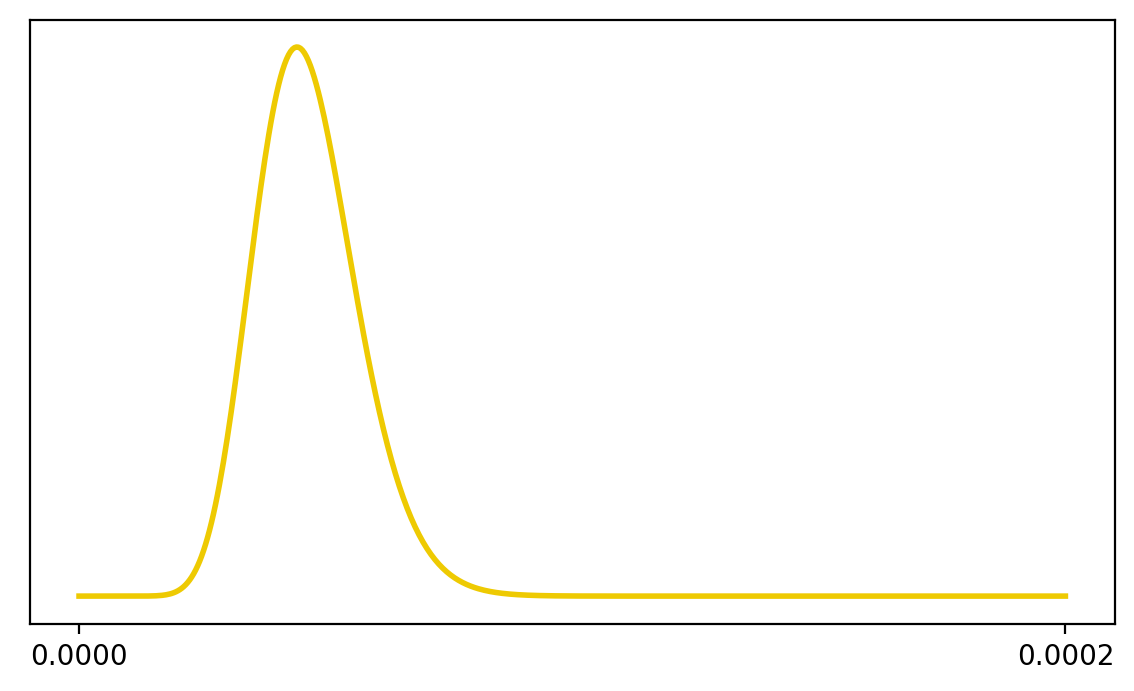

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
x2=np.linspace(0,20/1e5,500)
alpha=20
beta=430000
axes.plot(x2,stats.gamma.pdf(x2,a=alpha,scale=1/beta),color=dark,linewidth=2)
axes.set_yticks(())
axes.set_xticks([0,20/1e5])

plt.show()

In [136]:
with open('gamma_stan.stan', 'r') as file:
    print(file.read())

functions {
  // Difference between one-sided Gaussian tail probability and target probability
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.98;
    return deltas;
  }
}

data {
  vector[1] y_guess; // Initial guess of Gaussian standard deviation
  vector[1] theta;       // Target quantile
}

transformed data {
  vector[1] y;
  real x_r[0];
  int x_i[0];
  
  // Find Gaussian standard deviation that ensures 98% probabilty below 15
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);
  
  print("Standard deviation = ", exp(y[1]));
}

generated quantities {
    real sigma = exp(y[1]);
    real beta = (1 / theta[1]);
    real alpha = (sigma * beta) ^ 2;
    
    real gamma = gamma_rng(alpha, beta);
    print("Beta = ", beta);
    print("Alpha = ", alpha);
    print("Gamma = ", gamma);
}


In [137]:
model_prior=stan_utility.compile_model('gamma_stan.stan')

Using cached StanModel


In [142]:
theta=np.array([np.random.randint(low=1, high=10)])
y_guess=np.array([np.random.randint(low=1, high=10)])
data=dict(y_guess=y_guess,theta=theta)
model_prior2 = model_prior.sampling(data=data, algorithm="Fixed_param", iter=1, warmup=0, chains=1, seed=1052020)
sigma = np.round(model_prior2.extract()['sigma'][0])
gamma = np.round(model_prior2.extract()['gamma'][0])
beta = np.round(model_prior2.extract()['beta'][0])
alpha = np.round(model_prior2.extract()['alpha'][0])
print(sigma)
print(alpha)
print(beta)
print(gamma)

4.0
0.0
0.0
0.0


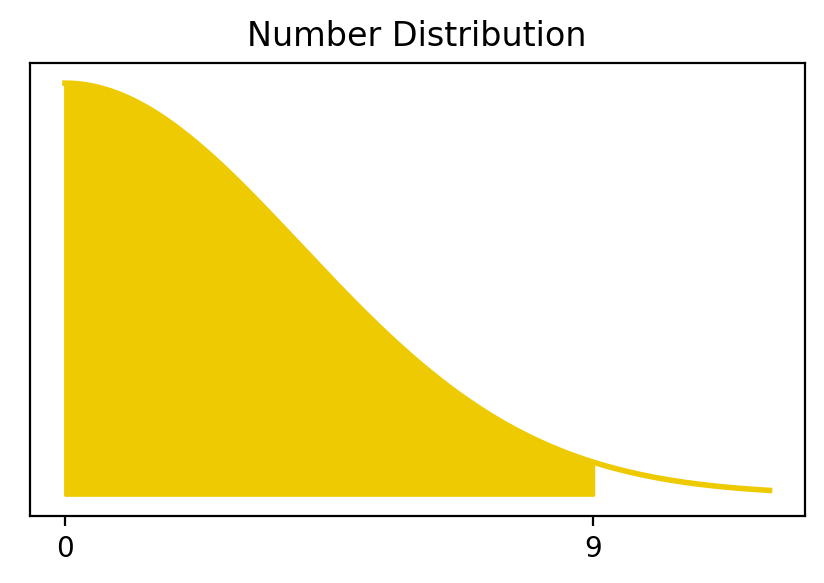

In [144]:
fig, ax2 = plt.subplots(1, 1,figsize=(5, 3))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,theta[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,theta[0]])
ax2.set_title('Number Distribution')
plt.show()

Negative binomial distribution